In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from sdebridge.setup import *
from sdebridge.sde import FourierGaussianKernelSDE
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.data_processing import butterfly_amasina_pts, butterfly_honrathi_pts
from sdebridge.utils import eval_score

from matplotlib import colormaps

2024-01-27 18:10:25.419809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 18:10:25.419843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 18:10:25.420878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 18:10:26.809023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

In [4]:
def sample_ellipse(
    n_samples: int,
    scale: float = 1.0,
    shifts: np.ndarray = np.array([0.0, 0.0]),
    a: float = 1.0,
    b: float = 1.0,
) -> np.ndarray:
    theta = np.linspace(0, 2 * np.pi, n_samples, endpoint=False)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    return scale * np.stack([x, y], axis=1) + shifts[None, :]

S0 shape:  (130, 2)
ST shape:  (120, 2)


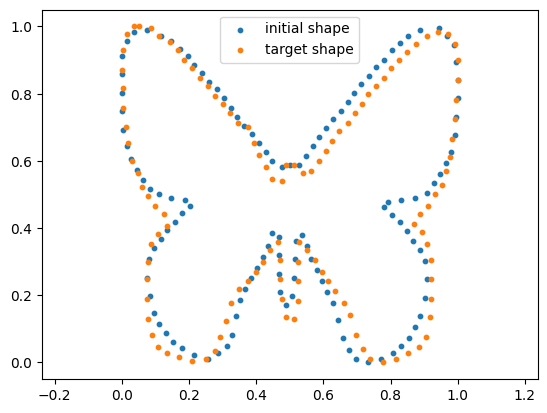

In [3]:
S0 = jnp.array(butterfly_honrathi_pts())[:, ::200][:, 1:].transpose()
ST = jnp.array(butterfly_amasina_pts())[:, ::200].transpose()

# S0 = sample_ellipse(64, scale=1.0, a=1.0, b=0.5)
# ST = sample_ellipse(64, scale=1.5, a=1.0, b=0.5)

print("S0 shape: ", S0.shape)
print("ST shape: ", ST.shape)
with jax.default_device(jax.devices('cpu')[0]):
    plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
    plt.scatter(ST[:, 0], ST[:, 1], s=10, label='target shape')
    plt.legend()
    plt.axis('equal')
    plt.show()

In [37]:
n_bases = 8

sde_config = ConfigDict(
    {
        'init_S': S0.flatten(),
        'T': 1.0,
        'N': 50,
        'dim': 2,
        'n_bases': n_bases,
        'sigma': 0.3,
        'alpha': 0.7,
    }
)
sde = FourierGaussianKernelSDE(sde_config)
bridge = DiffusionBridge(sde)

XT shape: 
 (8, 2)
XT (reconstructed) shape: 
 (130, 2)


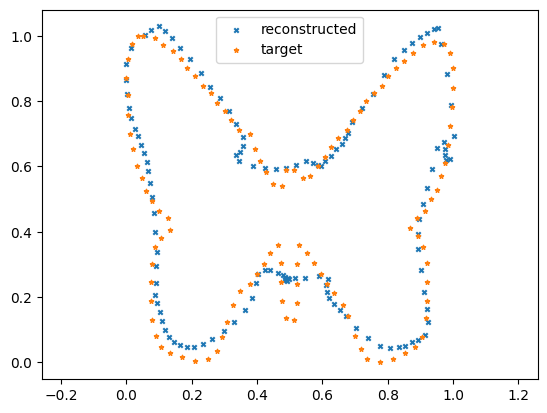

In [38]:
X0 = jnp.zeros((sde.dim*sde.n_bases, ), dtype=jnp.complex64)

S0_coeffs = jnp.fft.rfft(S0, norm="forward", n=S0.shape[0], axis=0)
ST_coeffs = jnp.fft.rfft(ST, norm="forward", n=ST.shape[0], axis=0)
XT_coeffs = ST_coeffs[:n_bases, :] - S0_coeffs[:n_bases, :]
print("XT shape: \n", XT_coeffs.shape)
XT_recon = jnp.fft.irfft(XT_coeffs, n=S0.shape[0], axis=0, norm="forward")
print("XT (reconstructed) shape: \n", XT_recon.shape)

ST_recon = S0 + XT_recon.real
with jax.default_device(jax.devices('cpu')[0]):
    plt.scatter(ST_recon[:, 0], ST_recon[:, 1], s=10, marker='x', label='reconstructed')
    plt.scatter(ST[:, 0], ST[:, 1], s=10, marker='*', label='target')
    plt.axis('equal')
    plt.legend()

In [39]:
forward_uncond = bridge.simulate_forward_process(
    initial_val = X0,
    num_batches = 4
)

Xs_coeffs = forward_uncond["trajectories"]
print("Xs_coeffs shape: \n", Xs_coeffs.shape)
Xs_coeffs = Xs_coeffs.reshape((Xs_coeffs.shape[0], Xs_coeffs.shape[1], 2, sde.n_bases))
Xs_recon = jnp.fft.irfft(Xs_coeffs, n=S0.shape[0], axis=3, norm="forward")
print("Xs_recon shape: \n", Xs_recon.shape)
Ss = S0[None, None, :, :] + jnp.swapaxes(Xs_recon, 2, 3)

Xs_coeffs shape: 
 (4, 50, 16)
Xs_recon shape: 
 (4, 50, 2, 130)


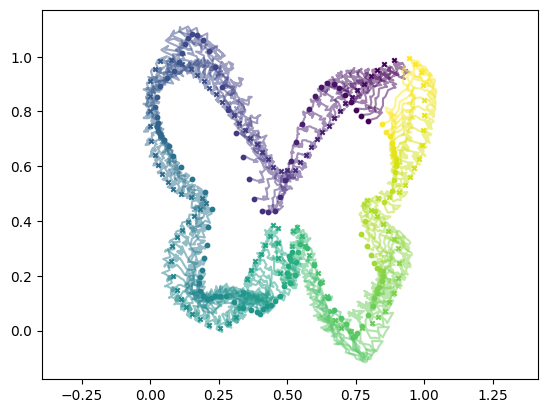

In [41]:
n = 2
cmap = colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, S0.shape[0]))
with jax.default_device(jax.devices('cpu')[0]):
    for i in range(S0.shape[0]):
        plt.scatter(Ss[n, 0, i, 0], Ss[n, 0, i, 1], s=10, marker='x', color=colors[i])
        plt.scatter(Ss[n, -1, i, 0], Ss[n, -1, i, 1], s=10, marker='o', color=colors[i])
        plt.plot(Ss[n, :, i, 0], Ss[n, :, i, 1], color=colors[i], alpha=0.5)
    plt.axis('equal')

In [50]:
setup_params = {
    "network": {
        "output_dim": sde.dim*sde.n_bases,
        "time_embedding_dim": 64,
        "bottleneck_dim": 8,
        "act_fn": "silu",
        "encoder_layer_dims": [64, 32, 16],
        "decoder_layer_dims": [64, 32, 16],
        "batchnorm": True,
    },
    "training": {
        "network_type": "UNet",
        "batch_size": 64,
        "num_epochs": 100,
        "num_batches_per_epoch": 300,
        "learning_rate": 1e-3,
        "warmup_steps": 2000,
    }
}

score_p_state = bridge.learn_p_score(
    initial_val=X0,
    setup_params=setup_params,
)

Training:   0%|          | 0/100 [00:29<?, ?epoch/s]


KeyboardInterrupt: 

In [58]:
score_p = partial(
    lambda val, time, score_p_state: eval_score(
        state=score_p_state,
        val=val,
        time=time,
    ),
    score_p_state=score_p_state
)
backward_brownian_bridge = bridge.simulate_backward_bridge(
    initial_val=X0,
    terminal_val=XT_coeffs,
    score_p=score_p,
    num_batches=4,
)

AssertionError: 